# Lezione 23

In [ ]:
from liblet import ANTLR, Table, Tree, Stack, AnnotatedTreeWalker, warn

## Code Threading

Seguendo l'approcco di MCD 5.1 e usando `SimpleBlockLang` come esempio, vediamo come fare il *threding* dei tre costrutti fondamentali: sequenza, selezione ed iterazione.

Al solito usiamo un `AnnotatedTreeWalker` per analizzare l'AST, che annoteremo aggiungendo ad ogni radice degli attributi per tenere "il filo" il cui nome sarà dato dal prefisso `_thread_`, la quale restituisce per ogni sottoalbero la *lista* dei sottoalberi "cuciti assieme".

In [ ]:
thread = AnnotatedTreeWalker('type')

Consideriamo un paio di funzioni, per aggiungere un "filo" (dato il nome e il nodo a cui deve collegarsi) e per estrarre tutti i fili (scordandosi dei prefissi). 

In [ ]:
def set_thread(ast, name, node):
  ast.root['_thread_' + name] = node

def get_threads(ast):
  return {k[8:]: v for k, v in ast.root.items() if k.startswith('_thread_')}

Date due liste di nodi, è possibile "cucirle assieme" concatenandole e aggiungendo un filo `next` dall'ultimo nodo della prima, al primo nodo della seconda.

In [ ]:
def concat_threads(prev, succ):
  if prev: set_thread(prev[-1], 'next', succ[0])
  return prev + succ

Per finire, un paio di funzioni di comodo:

* la prima per effettuare parsing, produzione dell'AST e annotazione del medesimo,
* la seconda che, dopo aver richiamato la precedente, ne visualizza il risultato.

In [ ]:
SimpleBlockLang = ANTLR.load('SimpleBlockLang.g')
simpleBlock2ast = AnnotatedTreeWalker.load('simpleBlock2ast.atw')

def do_threads(source):
  ast = simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))
  threads = concat_threads([Tree({'type': '<START>'})], thread(ast))
  set_thread(threads[-1], 'next', None)
  return ast, threads

def show_threads(source):
  ast, threads = do_threads(source)
  return ast.with_threads({t: get_threads(t) for t in threads})

### Sequenza

Per gestire la sequenza (che coinvolge tutti i nodi fatti salvi quelli di selezione ed iterazione) è sufficiente un catch-all che scarichi ricorsivamente e colleghi ogni nodo al successivo.

In [ ]:
@thread.catchall
def catchall(visit, ast):

  threads = []
  for child in ast.children: 
    threads = concat_threads(threads, visit(child)) 

  return concat_threads(threads, [ast])

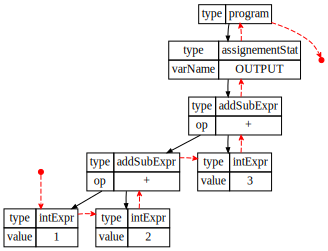

In [ ]:
show_threads("""
OUTPUT = 1 + 2 + 3;
""")

#### Sistemiamo i blocchi

Va sistemato il fatto che il catch-all torna al blocco

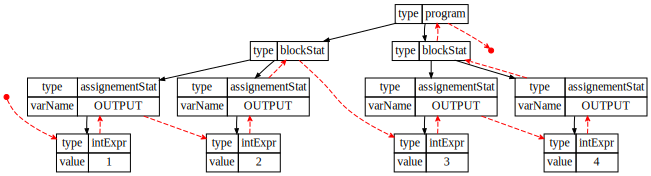

In [ ]:
source = """
{ OUTPUT = 1; OUTPUT = 2; }
{ OUTPUT = 3; OUTPUT = 4; }
"""
show_threads(source)

Basta evitare di riportare l'ultimo nodo verso il blocco (le ultime due righe del catch-all)

In [ ]:
@thread.register
def blockStat(visit, ast):

  threads = []
  for child in ast.children: 
    threads = concat_threads(threads, visit(child)) 

  return threads

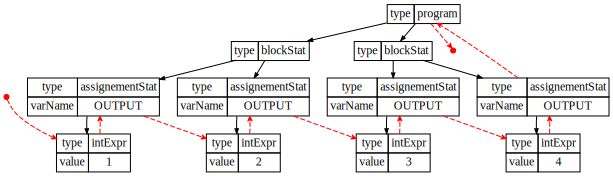

In [ ]:
show_threads(source)

### Selezione

Per la selzione è necessario creare un nodo di tipo `<JOIN>` per mettere assieme i due thread del ramo "true" e "false" nonché sostituire l'usuale salto `next` con un salto per ramo.

In [ ]:
@thread.register
def ifElseStat(visit, ast):

  cond, true, false = ast.children

  threads = concat_threads(visit(cond), [ast])
  true_threads = visit(true)
  false_threads = visit(false)

  join = Tree({'type': '<JOIN>'})

  if true_threads:
    set_thread(ast, 'true', true_threads[0])
    set_thread(true_threads[-1], 'next', join)
    threads += true_threads
  else:
    set_thread(ast, 'true', join)

  if false_threads:
    set_thread(ast, 'false', false_threads[0])
    set_thread(false_threads[-1], 'next', join)
    threads += false_threads
  else:
    set_thread(ast, 'false', join)

  return threads + [join]

Vediamo un esempio

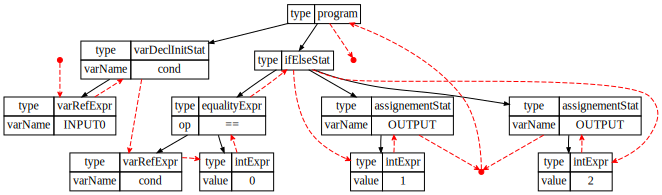

In [ ]:
show_threads("""
var cond = INPUT0;

if cond == 0 then 
  OUTPUT = 1;
else
  OUTPUT = 2;
""")

### Iterazione

Per finire, l'iterazione; non c'è bisogno di un nodo extra, basta usare il salto `next` per il caso in cui l'iterazione sia esaurita, e un salto `repeat` in caso contrario.

In [ ]:
@thread.register
def repeatStat(visit, ast):

  count, stat = ast.children

  count_threads = visit(count)
  stat_threads = visit(stat)
  
  set_thread(count_threads[-1], 'next', ast)
  set_thread(ast, 'repeat', stat_threads[0] if stat_threads else ast)

  return count_threads + concat_threads(stat_threads, [ast])

Un piccolo esempio

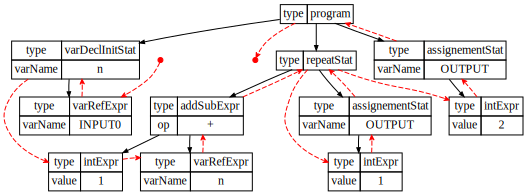

In [ ]:
show_threads("""
var n = INPUT0;
repeat 1 + n times 
  OUTPUT = 1;
OUTPUT = 2;
""")

## Un esempio completo

Vediamo un esempio completo, che usremo nella costruzione dell'interprete. Contiene un campionario delle possibili istruzioni ed operazioni…

In [ ]:
# se INPUT0 è 0 restituisce 2 * INPUT1, altrimenti restituisce 123456

source = """
var sel = INPUT0;
var n = INPUT1;

var res;

if sel == 0 then {
  res = 0;
  repeat n times
    repeat 2 times
      res = res + 1;
} else 
  res = 123456;

OUTPUT = res;
"""

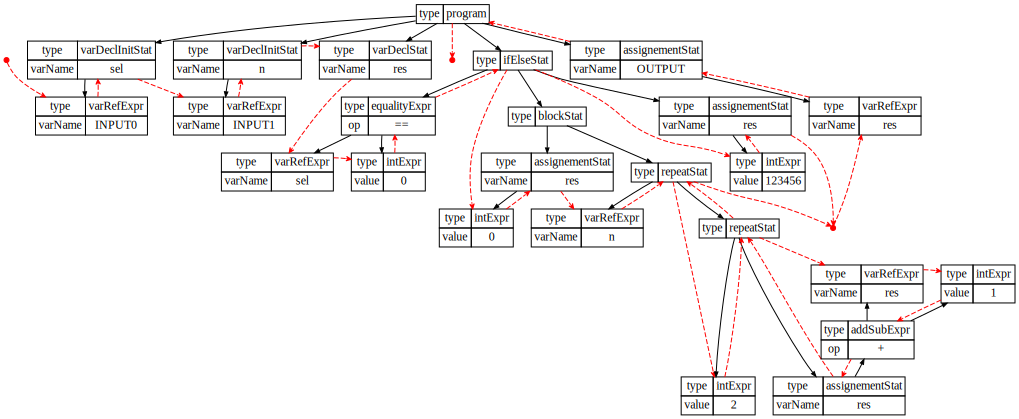

In [ ]:
show_threads(source)

## Interprete

### Istruzioni e salti

Per prima cosa, semplifichiamo i fili tenendo da parte solo le istruzioni ed i salti, iniziamo col trasformare ogni nodo (da usare nei salti) in un numero progressivo, dopo aver numerato i nodi…

In [ ]:
def to_program(threads):
  program = Table(2)
  for n, t in enumerate(threads):
    program[n, 'instr'] = {k: v for k, v in t.root.items() if not k.startswith('_thread_')}
    program[n, 'jumps'] = {k: threads.index(v) if v else None for k, v in get_threads(t).items()}
  return program

In [ ]:
_, threads = do_threads(source)
program = to_program(threads)

In [ ]:
program

### L'interprete iterativo

Per costruire l'interprete ci serve uno `STACK` dove conservare il risultato intermedio delle operazioni e una `GLOBAL_MEMORY` per memorizzare le variabili globali (qui per semplicità non ci occupiamo dello scoping di blocco).

In [ ]:
def interpreter(program, indct, trace = False):

  GLOBAL_MEMORY = indct.copy()
  STACK = Stack()
  IP = 0
  while True:

    # Fetch

    instr, jumps = program[IP, 'instr'], program[IP, 'jumps']

    # Siamo alla fine?

    if 'next' in jumps and jumps['next'] == None: break 

    # Tracing

    if trace: print(IP, instr, jumps, STACK)

    # Decoding ed esecuzione

    IP = None

    if instr['type'] == 'intExpr':
      STACK.push(instr['value'])

    elif instr['type'] == 'addSubExpr':
      if instr['op'] == '-':
        STACK.push(-STACK.pop() + STACK.pop())
      elif instr['op'] == '+':
        STACK.push(STACK.pop() + STACK.pop())

    elif instr['type'] == 'equalityExpr':
      STACK.push(STACK.pop() == STACK.pop())

    elif instr['type'] == 'varRefExpr':
      STACK.push(GLOBAL_MEMORY[instr['varName']])

    elif instr['type'] == 'varDeclStat':
      GLOBAL_MEMORY[instr['varName']] = 0

    elif instr['type'] == 'varDeclInitStat':
      GLOBAL_MEMORY[instr['varName']] = STACK.pop()

    elif instr['type'] == 'assignementStat':
      GLOBAL_MEMORY[instr['varName']] = STACK.pop()

    elif instr['type'] == 'ifElseStat':
      IP = jumps['true'] if STACK.pop() else jumps['false']

    elif instr['type'] == 'repeatStat':
      count = STACK.pop()
      if count > 0:
        STACK.push(count - 1)
        IP = jumps['repeat']
      else:
        IP = jumps['next']

    elif instr['type'] in ('<START>', '<JOIN>'):
      pass # ignoro l'inizio e i join

    else:
      # ma emetto warning per le istruzioni
      # di cui questa implementazione parziale 
      # ancora non si occupa

      warn('ignoring: ' + instr['type'])

    # se selezione o iterazione non hanno riassegnato IP, passo al `next`         
    if IP is None: IP = jumps['next']
  
  return GLOBAL_MEMORY['OUTPUT']

Eseguiamo il ramo false

In [ ]:
interpreter(program, {'INPUT0': 1, 'INPUT1': 3}, True)

0 {'type': '<START>'} {'next': 1} Stack()
1 {'type': 'varRefExpr', 'varName': 'INPUT0'} {'next': 2} Stack()
2 {'type': 'varDeclInitStat', 'varName': 'sel'} {'next': 3} Stack(1 ↔)
3 {'type': 'varRefExpr', 'varName': 'INPUT1'} {'next': 4} Stack()
4 {'type': 'varDeclInitStat', 'varName': 'n'} {'next': 5} Stack(3 ↔)
5 {'type': 'varDeclStat', 'varName': 'res'} {'next': 6} Stack()
6 {'type': 'varRefExpr', 'varName': 'sel'} {'next': 7} Stack()
7 {'type': 'intExpr', 'value': 0} {'next': 8} Stack(1 ↔)
8 {'type': 'equalityExpr', 'op': '=='} {'next': 9} Stack(1, 0 ↔)
9 {'type': 'ifElseStat'} {'true': 10, 'false': 20} Stack(False ↔)
20 {'type': 'intExpr', 'value': 123456} {'next': 21} Stack()
21 {'type': 'assignementStat', 'varName': 'res'} {'next': 22} Stack(123456 ↔)
22 {'type': '<JOIN>'} {'next': 23} Stack()
23 {'type': 'varRefExpr', 'varName': 'res'} {'next': 24} Stack()
24 {'type': 'assignementStat', 'varName': 'OUTPUT'} {'next': 25} Stack(123456 ↔)


123456

E ora quello true…

In [ ]:
interpreter(program, {'INPUT0': 0, 'INPUT1': 10})    

20